In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# sklearn :: evaluation metrics
from sklearn.metrics import cohen_kappa_score

sns.set_style('whitegrid')
pd.set_option('display.max_columns',250)

# Problem definition

Apply classification models to predict the museum rating (stars). Classes were mapped to museum ratings as follows:

1: 2.5 stars (No museums in the dataset were rated less than 2.5.)  
2: 3 stars  
3: 3.5 stars  
4: 4 stars  
5: 4.5 stars  
6: 5 stars  

# Load the data

In [2]:
df = pd.read_csv('data/museum_data.csv')

In [3]:
# define columns ranges
review_columns = ['Excellent','Very Good','Average','Poor','Terrible']
traveler_columns = ['Families', 'Couples', 'Solo', 'Business', 'Friends']
categories = list(df.loc[:,'Ancient Ruins':'Zoos & Aquariums'].columns)
tags = list(df.loc[:,'on display':'life size'].columns)

# Feature Engineering

In [4]:
print(df.columns)
df.head()

Index(['MuseumName', 'Address', 'Continent', 'SubRegion', 'Country', 'CityUS',
       'StateUS', 'Rating', 'ReviewCount', 'FeatureCount',
       ...
       'take pictures', 'admission', 'great place to learn',
       'enjoyed our visit', 'special exhibitions', 'suggested donation',
       'displays', 'old west', 'learn something', 'life size'],
      dtype='object', length=201)


,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo,Excellent,Very Good,Average,Poor,Terrible,Families,Couples,Solo,Business,Friends,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,Bodies of Water,Bridges,Castles,Cemeteries,Children's Museums,City Tours,Classes & Workshops,Coffeehouses,Concerts & Shows,Cultural Tours,Educational sites,Factory Tours,Flea & Street Markets,Food & Drink,Fun & Games,Game & Entertainment Centers,Gardens,Geologic Formations,Gift & Specialty Shops,Government Buildings,Historic Sites,Historic Walking Areas,Historical & Heritage Tours,History Museums,Islands,Lessons & Workshops,Libraries,Lighthouses,"Literary, Art & Music Tours",Lookouts,Military Bases & Facilities,Military Museums,Mines,Monuments & Statues,Movie Theaters,Museums,National Parks,Natural History Museums,Nature & Parks,Nature & Wildlife Areas,Neighborhoods,Night Tours,Nightlife,Observation Decks & Towers,Observatories & Planetariums,Other Fun & Games,Other Outdoor Activities,Outdoor Activities,Piers & Boardwalks,Playgrounds,Points of Interest & Landmarks,Private Tours,Sacred & Religious Sites,Scenic Railroads,Scenic Walking Areas,Science Museums,Self-Guided Tours & Rentals,Ships,Shopping,Sights & Landmarks,Specialty Museums,Sports Complexes,State Parks,Theaters,Tours,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,two hours,free admission,worth a visit,audio guide,exhibits,beautiful building,great collection,interesting exhibits,interactive exhibits,entrance fee,hands on activities,great for kids,information,great exhibits,interactive displays,guided tour,great place to visit,his life,traveling exhibits,kids and adults,local history,amazing collection,whole family,well worth the visit,free entry,civil war,great history,take your time,nice collection,worth the trip,van gogh,for sale,great museum,interesting place,art lovers,audio tour,natural history,history,artifacts,private collection,works of art,self guided tour,moving experience,sculpture garden,own pace,galleries,three hours,lots of history,small museum,history buff,modern art,worth a stop,short film,stuffed animals,step back in time,scavenger hunt,world war,across the street,entry fee,walk around,large collection,history lesson,top floor,great displays,interesting artifacts,three floors,rotating exhibits,american history,eye opening,a lot of fun,old masters,early days,changing exhibits,collection,extensive collection,chronological order,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size
0,The Field Museum,"1400 S Lake Shore Dr, Chicago, IL 60605-2827",Americas,Northern America,USA,Chicago,IL,4.5,5500,4,9,614,2931.0,1278.0,427.0,102.0,30.0,1612,1217,277,158,597,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Smithsonian National Museum of Natural History,"10th Street and Constitution Ave, Washington D...",Americas,Northern America,USA,Washington DC,DC,4.5,7640,7,12,398,4158.0,1577.0,524.0,104.0,27.0,2558,1439,401,222,666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0

In [5]:
# map ratings to categories the algorithm can interpret

ratings = list(df['Rating'].value_counts().sort_index().index)
rating_map = {}

for i, ID in enumerate(ratings):
    rating_map.update({ID : (i+1)})
    
new_ratingID = {i : k for i, k in rating_map.items()}

df['RatingID'] = df.Rating.replace(new_ratingID)
df['RatingID']=df['RatingID'].astype(int)

In [6]:
# create features

# ratios of review types out of the total reviews
df.loc[:,'%Excellent']= df['Excellent']/df[review_columns].sum(axis=1)*100
df.loc[:,'%Very Good']= df['Very Good']/df[review_columns].sum(axis=1)*100
df.loc[:,'%Average']= df['Average']/df[review_columns].sum(axis=1)*100
df.loc[:,'%Poor']= df['Poor']/df[review_columns].sum(axis=1)*100
df.loc[:,'%Terrible']= df['Terrible']/df[review_columns].sum(axis=1)*100

# ratios of traveler types out of the total travelers
df.loc[:,'%Families']= df['Families']/df[traveler_columns].sum(axis=1)*100
df.loc[:,'%Couples']= df['Couples']/df[traveler_columns].sum(axis=1)*100
df.loc[:,'%Solo']= df['Solo']/df[traveler_columns].sum(axis=1)*100
df.loc[:,'%Business']= df['Business']/df[traveler_columns].sum(axis=1)*100
df.loc[:,'%Friends']= df['Friends']/df[traveler_columns].sum(axis=1)*100

# relative ranking based on the number of things to do, and inverse (higher value = more popular)
df['RelativeRank'] = df['Rank']/df['TotalThingsToDo']
df['InvRelativeRank'] = 1/df['RelativeRank']

In [7]:
# map subregion and continent to numeric

# continentID
continents = list(df['Continent'].value_counts().index)
continent_map = {}

for i, ID in enumerate(continents):
    continent_map.update({ID : (i+1)})
    
new_continentID = {i : k for i, k in continent_map.items()}

df['ContinentID'] = df.Continent.replace(new_continentID)

# subregion ID
subregions = list(df['SubRegion'].value_counts().index)
subregion_map = {}

for i, ID in enumerate(subregions):
    subregion_map.update({ID : (i+1)})
    
new_subregionID = {i : k for i, k in subregion_map.items()}

df['SubRegionID'] = df.SubRegion.replace(new_subregionID)

In [8]:
df.head()

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo,Excellent,Very Good,Average,Poor,Terrible,Families,Couples,Solo,Business,Friends,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,Bodies of Water,Bridges,Castles,Cemeteries,Children's Museums,City Tours,Classes & Workshops,Coffeehouses,Concerts & Shows,Cultural Tours,Educational sites,Factory Tours,Flea & Street Markets,Food & Drink,Fun & Games,Game & Entertainment Centers,Gardens,Geologic Formations,Gift & Specialty Shops,Government Buildings,Historic Sites,Historic Walking Areas,Historical & Heritage Tours,History Museums,Islands,Lessons & Workshops,Libraries,Lighthouses,"Literary, Art & Music Tours",Lookouts,Military Bases & Facilities,Military Museums,Mines,Monuments & Statues,Movie Theaters,Museums,National Parks,Natural History Museums,Nature & Parks,Nature & Wildlife Areas,Neighborhoods,Night Tours,Nightlife,Observation Decks & Towers,Observatories & Planetariums,Other Fun & Games,Other Outdoor Activities,Outdoor Activities,Piers & Boardwalks,Playgrounds,Points of Interest & Landmarks,Private Tours,Sacred & Religious Sites,Scenic Railroads,Scenic Walking Areas,Science Museums,Self-Guided Tours & Rentals,Ships,Shopping,Sights & Landmarks,Specialty Museums,Sports Complexes,State Parks,Theaters,Tours,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,two hours,free admission,worth a visit,audio guide,exhibits,beautiful building,great collection,interesting exhibits,interactive exhibits,entrance fee,hands on activities,great for kids,information,great exhibits,interactive displays,guided tour,great place to visit,his life,traveling exhibits,kids and adults,local history,amazing collection,whole family,well worth the visit,free entry,civil war,great history,take your time,nice collection,worth the trip,van gogh,for sale,great museum,interesting place,art lovers,audio tour,natural history,history,artifacts,private collection,works of art,self guided tour,moving experience,sculpture garden,own pace,galleries,three hours,lots of history,small museum,history buff,modern art,worth a stop,short film,stuffed animals,step back in time,scavenger hunt,world war,across the street,entry fee,walk around,large collection,history lesson,top floor,great displays,interesting artifacts,three floors,rotating exhibits,american history,eye opening,a lot of fun,old masters,early days,changing exhibits,collection,extensive collection,chronological order,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size,RatingID,%Excellent,%Very Good,%Average,%Poor,%Terrible,%Families,%Couples,%Solo,%Business,%Friends,RelativeRank,InvRelativeRank,ContinentID,SubRegionID
0,The Field Museum,"1400 S Lake Shore Dr, Chicago, IL 60605-2827",Americas,Northern America,USA,Chicago,IL,4.5,5500,4,9,614,2931.0,1278.0,427.0,102.0,30.0,1612,1217,277,158,597,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,61.472315,26.803691,8.955537,2.139262,0.629195,41.750842,31.520332,7.174307,4.092204,15.462315,0.014658,68.222222,1,1
1,Smithsonian National Museum of Natural Histor

In [9]:
non_numeric_columns = ['MuseumName','Address','Continent','SubRegion','CityUS','StateUS','Rating']
review_percent_columns = ['%Excellent','%Very Good', '%Average','%Poor','%Terrible']
traveler_percent_columns = ['%Families','%Couples','%Solo','%Business','%Friends']
numeric_columns = ['ReviewCount','FeatureCount','Rank','TotalThingsToDo','RelativeRank','InvRelativeRank','ContinentID','SubRegionID']
# based on feature importances with all categories
important_categories = ['Specialty Museums','History Museums','Art Museums','Military Museums','Science Museums','Libraries','Shopping','Gardens',"Children's Museums",'Natural History Museums','Sights & Landmarks','Historic Sites','Movie Theaters']

In [14]:
# select the columns
X_columns = numeric_columns + traveler_percent_columns + categories + tags
y_column = ['RatingID']

# Model Training

In [29]:
# split the data using sklearn

threshold = 0.8
X = df[X_columns]
y = df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (1274, 192)
y_train (1274, 1)
X_test (319, 192)
y_test (319, 1)


In [30]:
# TODO: try different models
models = [
    ('GaussianNB', GaussianNB()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('RandomForestClassifier 10', RandomForestClassifier(10)),
    ('RandomForestClassifier 100', RandomForestClassifier(100)),
    ('RandomForestClassifier 200', RandomForestClassifier(200))
]
results = []
for m in models:
    print('MODEL', m[0])
    model = m[1]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred, weights ='quadratic')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    print(confusion_matrix(y_test, y_pred))
    print('kappa', round(kappa, 4))
    print('Precision', precision)
    print('Recall', recall)
    print('')
    results.append([m[0], kappa, precision, recall])
    
    # if there is a feature importance, print top 10
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False))
    elif hasattr(model, 'coef_'):
        print('Feature Importance')
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.coef_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False))
        
    print('')

# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'kappa', 'precision', 'recall']
df_results = df_results.sort_values(by='kappa', ascending=False)
df_results

MODEL GaussianNB
[[ 0  1  0  0  0]
 [ 0  3  4  0  0]
 [ 0 15 25 10  0]
 [ 0 36 78 71 52]
 [ 0  4  1  2 17]]
kappa 0.2817
Precision 0.36363636363636365
Recall 0.36363636363636365


MODEL KNeighborsClassifier
[[  0   0   1   0   0]
 [  0   0   1   6   0]
 [  0   1   6  43   0]
 [  0   0  27 202   8]
 [  0   0   2  20   2]]
kappa 0.1179
Precision 0.658307210031348
Recall 0.658307210031348


MODEL DecisionTreeClassifier
[[  0   1   0   0   0]
 [  0   1   3   3   0]
 [  0   4  24  21   1]
 [  0   2  33 185  17]
 [  0   0   0  13  11]]
kappa 0.4711
Precision 0.6927899686520376
Recall 0.6927899686520376

Feature Importance
                                    0         1
2                                Rank  0.120960
0                         ReviewCount  0.113973
5                     InvRelativeRank  0.073119
4                        RelativeRank  0.072989
9                            %Couples  0.067447
10                              %Solo  0.062807
11                          %Business  0

C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[  0   1   0   0   0]
 [  0   3   2   2   0]
 [  0   1  19  30   0]
 [  0   1  14 218   4]
 [  0   0   0  19   5]]
kappa 0.5082
Precision 0.768025078369906
Recall 0.768025078369906

Feature Importance
                                0         1
2                            Rank  0.220840
0                     ReviewCount  0.098546
4                    RelativeRank  0.089388
5                 InvRelativeRank  0.085201
9                        %Couples  0.060601
12                       %Friends  0.040275
8                       %Families  0.035005
10                          %Solo  0.032874
6                     ContinentID  0.030294
3                 TotalThingsToDo  0.029297
11                      %Business  0.022695
7                     SubRegionID  0.019036
123                      his life  0.016441
136                      van gogh  0.012022
175                  a lot of fun  0.009502
86                          Tours  0.007462
1                    FeatureCount  0.005305
145   

C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


[[  0   0   1   0   0]
 [  0   0   4   3   0]
 [  0   0  16  34   0]
 [  0   0   9 228   0]
 [  0   0   0  23   1]]
kappa 0.3591
Precision 0.768025078369906
Recall 0.768025078369906

Feature Importance
                                    0             1
2                                Rank  8.140582e-02
5                     InvRelativeRank  7.811075e-02
4                        RelativeRank  7.315574e-02
0                         ReviewCount  5.618092e-02
3                     TotalThingsToDo  5.059469e-02
10                              %Solo  4.871375e-02
11                          %Business  4.759629e-02
12                           %Friends  4.618252e-02
8                           %Families  4.559965e-02
9                            %Couples  4.554562e-02
7                         SubRegionID  1.974571e-02
1                        FeatureCount  1.672796e-02
6                         ContinentID  1.414939e-02
82                  Specialty Museums  1.004626e-02
123               

C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


[[  0   0   1   0   0]
 [  0   0   4   3   0]
 [  0   0  16  34   0]
 [  0   0   7 229   1]
 [  0   0   0  23   1]]
kappa 0.3656
Precision 0.7711598746081505
Recall 0.7711598746081505

Feature Importance
                                    0             1
4                        RelativeRank  7.835180e-02
2                                Rank  7.729758e-02
5                     InvRelativeRank  7.439457e-02
0                         ReviewCount  5.586563e-02
3                     TotalThingsToDo  5.394540e-02
12                           %Friends  4.806228e-02
11                          %Business  4.764571e-02
10                              %Solo  4.754914e-02
8                           %Families  4.643604e-02
9                            %Couples  4.603929e-02
7                         SubRegionID  1.831681e-02
1                        FeatureCount  1.798664e-02
6                         ContinentID  1.411251e-02
97                         on display  1.075358e-02
98              

,model,kappa,precision,recall
3,GradientBoostingClassifier,0.508164,0.768025,0.768025
2,DecisionTreeClassifier,0.471115,0.692790,0.692790
4,RandomForestClassifier 10,0.381043,0.724138,0.724138
6,RandomForestClassifier 200,0.365627,0.771160,0.771160
5,RandomForestClassifier 100,0.359079,0.768025,0.768025
0,GaussianNB,0.281672,0.363636,0.363636
1,KNeighborsClassifier,0.117925,0.658307,0.658307


MODEL GaussianNB
MODEL KNeighborsClassifier
MODEL DecisionTreeClassifier
MODEL GradientBoostingClassifier
MODEL RandomForestClassifier 10
MODEL RandomForestClassifier 100
MODEL RandomForestClassifier 200


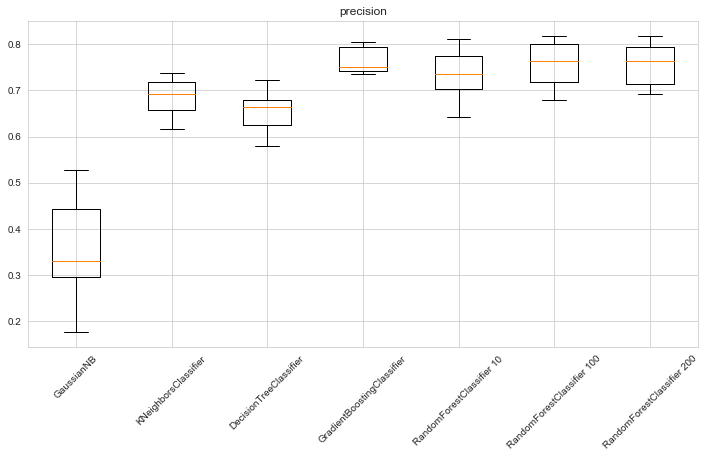

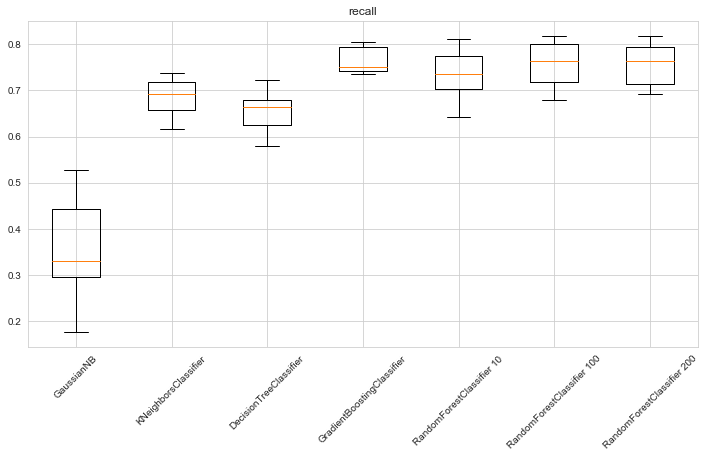

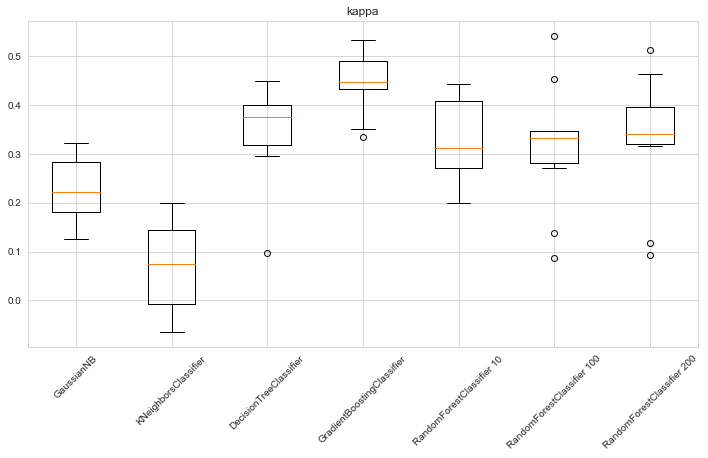

In [17]:
k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'precision':[], 'recall':[], 'kappa':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        kappa = cohen_kappa_score(y_test, y_pred, weights ='quadratic')
        precision = precision_score(y_test, y_pred, average='micro')
        recall = recall_score(y_test, y_pred, average='micro')
        results[m[0]]['precision'].append(precision)
        results[m[0]]['recall'].append(recall)
        results[m[0]]['kappa'].append(kappa)
for metric in ['precision', 'recall', 'kappa']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation=45)
    plt.show()

# Error Analysis

In [31]:
df_test = pd.DataFrame(X_test).copy()
df_test['rating'] = y_test
df_test['prediction'] = y_pred
df_test['abs_error'] = abs(df_test['rating']-df_test['prediction'])
df_test.sort_values(by='abs_error', ascending=False).round()

,ReviewCount,FeatureCount,Rank,TotalThingsToDo,RelativeRank,InvRelativeRank,ContinentID,SubRegionID,%Families,%Couples,%Solo,%Business,%Friends,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,Bodies of Water,Bridges,Castles,Cemeteries,Children's Museums,City Tours,Classes & Workshops,Coffeehouses,Concerts & Shows,Cultural Tours,Educational sites,Factory Tours,Flea & Street Markets,Food & Drink,Fun & Games,Game & Entertainment Centers,Gardens,Geologic Formations,Gift & Specialty Shops,Government Buildings,Historic Sites,Historic Walking Areas,Historical & Heritage Tours,History Museums,Islands,Lessons & Workshops,Libraries,Lighthouses,"Literary, Art & Music Tours",Lookouts,Military Bases & Facilities,Military Museums,Mines,Monuments & Statues,Movie Theaters,Museums,National Parks,Natural History Museums,Nature & Parks,Nature & Wildlife Areas,Neighborhoods,Night Tours,Nightlife,Observation Decks & Towers,Observatories & Planetariums,Other Fun & Games,Other Outdoor Activities,Outdoor Activities,Piers & Boardwalks,Playgrounds,Points of Interest & Landmarks,Private Tours,Sacred & Religious Sites,Scenic Railroads,Scenic Walking Areas,Science Museums,Self-Guided Tours & Rentals,Ships,Shopping,Sights & Landmarks,Specialty Museums,Sports Complexes,State Parks,Theaters,Tours,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,two hours,free admission,worth a visit,audio guide,exhibits,beautiful building,great collection,interesting exhibits,interactive exhibits,entrance fee,hands on activities,great for kids,information,great exhibits,interactive displays,guided tour,great place to visit,his life,traveling exhibits,kids and adults,local history,amazing collection,whole family,well worth the visit,free entry,civil war,great history,take your time,nice collection,worth the trip,van gogh,for sale,great museum,interesting place,art lovers,audio tour,natural history,history,artifacts,private collection,works of art,self guided tour,moving experience,sculpture garden,own pace,galleries,three hours,lots of history,small museum,history buff,modern art,worth a stop,short film,stuffed animals,step back in time,scavenger hunt,world war,across the street,entry fee,walk around,large collection,history lesson,top floor,great displays,interesting artifacts,three floors,rotating exhibits,american history,eye opening,a lot of fun,old masters,early days,changing exhibits,collection,extensive collection,chronological order,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size,rating,prediction,abs_error
161,687,0,397,1028,0.0,3.0,1,1,2.0,55.0,10.0,1.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,3
764,159,0,1,2,0.0,2.0,1,1,40.0,26.0,11.0,5.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

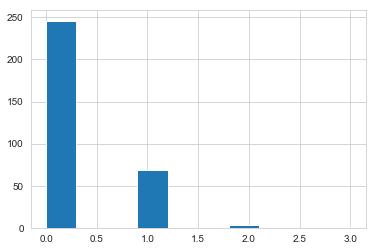

In [32]:
plt.hist(df_test['abs_error'])
plt.show()

In [33]:
df_error = df_test[df_test['abs_error']>1]
df_error

,ReviewCount,FeatureCount,Rank,TotalThingsToDo,RelativeRank,InvRelativeRank,ContinentID,SubRegionID,%Families,%Couples,%Solo,%Business,%Friends,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,Bodies of Water,Bridges,Castles,Cemeteries,Children's Museums,City Tours,Classes & Workshops,Coffeehouses,Concerts & Shows,Cultural Tours,Educational sites,Factory Tours,Flea & Street Markets,Food & Drink,Fun & Games,Game & Entertainment Centers,Gardens,Geologic Formations,Gift & Specialty Shops,Government Buildings,Historic Sites,Historic Walking Areas,Historical & Heritage Tours,History Museums,Islands,Lessons & Workshops,Libraries,Lighthouses,"Literary, Art & Music Tours",Lookouts,Military Bases & Facilities,Military Museums,Mines,Monuments & Statues,Movie Theaters,Museums,National Parks,Natural History Museums,Nature & Parks,Nature & Wildlife Areas,Neighborhoods,Night Tours,Nightlife,Observation Decks & Towers,Observatories & Planetariums,Other Fun & Games,Other Outdoor Activities,Outdoor Activities,Piers & Boardwalks,Playgrounds,Points of Interest & Landmarks,Private Tours,Sacred & Religious Sites,Scenic Railroads,Scenic Walking Areas,Science Museums,Self-Guided Tours & Rentals,Ships,Shopping,Sights & Landmarks,Specialty Museums,Sports Complexes,State Parks,Theaters,Tours,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,two hours,free admission,worth a visit,audio guide,exhibits,beautiful building,great collection,interesting exhibits,interactive exhibits,entrance fee,hands on activities,great for kids,information,great exhibits,interactive displays,guided tour,great place to visit,his life,traveling exhibits,kids and adults,local history,amazing collection,whole family,well worth the visit,free entry,civil war,great history,take your time,nice collection,worth the trip,van gogh,for sale,great museum,interesting place,art lovers,audio tour,natural history,history,artifacts,private collection,works of art,self guided tour,moving experience,sculpture garden,own pace,galleries,three hours,lots of history,small museum,history buff,modern art,worth a stop,short film,stuffed animals,step back in time,scavenger hunt,world war,across the street,entry fee,walk around,large collection,history lesson,top floor,great displays,interesting artifacts,three floors,rotating exhibits,american history,eye opening,a lot of fun,old masters,early days,changing exhibits,collection,extensive collection,chronological order,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size,rating,prediction,abs_error
161,687,0,397,1028,0.386187,2.589421,1,1,1.881720,54.838710,10.215054,1.075269,31.989247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,3
764,159,0,1,2,0.500000,2.000000,1,1,40.000000,25.714286,11.428571,4.761905,18.095238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [34]:
df_error.describe()

,ReviewCount,FeatureCount,Rank,TotalThingsToDo,RelativeRank,InvRelativeRank,ContinentID,SubRegionID,%Families,%Couples,%Solo,%Business,%Friends,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,Bodies of Water,Bridges,Castles,Cemeteries,Children's Museums,City Tours,Classes & Workshops,Coffeehouses,Concerts & Shows,Cultural Tours,Educational sites,Factory Tours,Flea & Street Markets,Food & Drink,Fun & Games,Game & Entertainment Centers,Gardens,Geologic Formations,Gift & Specialty Shops,Government Buildings,Historic Sites,Historic Walking Areas,Historical & Heritage Tours,History Museums,Islands,Lessons & Workshops,Libraries,Lighthouses,"Literary, Art & Music Tours",Lookouts,Military Bases & Facilities,Military Museums,Mines,Monuments & Statues,Movie Theaters,Museums,National Parks,Natural History Museums,Nature & Parks,Nature & Wildlife Areas,Neighborhoods,Night Tours,Nightlife,Observation Decks & Towers,Observatories & Planetariums,Other Fun & Games,Other Outdoor Activities,Outdoor Activities,Piers & Boardwalks,Playgrounds,Points of Interest & Landmarks,Private Tours,Sacred & Religious Sites,Scenic Railroads,Scenic Walking Areas,Science Museums,Self-Guided Tours & Rentals,Ships,Shopping,Sights & Landmarks,Specialty Museums,Sports Complexes,State Parks,Theaters,Tours,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,two hours,free admission,worth a visit,audio guide,exhibits,beautiful building,great collection,interesting exhibits,interactive exhibits,entrance fee,hands on activities,great for kids,information,great exhibits,interactive displays,guided tour,great place to visit,his life,traveling exhibits,kids and adults,local history,amazing collection,whole family,well worth the visit,free entry,civil war,great history,take your time,nice collection,worth the trip,van gogh,for sale,great museum,interesting place,art lovers,audio tour,natural history,history,artifacts,private collection,works of art,self guided tour,moving experience,sculpture garden,own pace,galleries,three hours,lots of history,small museum,history buff,modern art,worth a stop,short film,stuffed animals,step back in time,scavenger hunt,world war,across the street,entry fee,walk around,large collection,history lesson,top floor,great displays,interesting artifacts,three floors,rotating exhibits,american history,eye opening,a lot of fun,old masters,early days,changing exhibits,collection,extensive collection,chronological order,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size,rating,prediction,abs_error
count,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.00
mean,652.750000,0.25,103.750000,278.000000,0.326011,3.806446,1.5,2.5,23.642213,47.742405,8.243886,1.970539,18.400958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [35]:
df_error.corr()['abs_error'].dropna().sort_values()

rating              -1.000000
prediction          -1.000000
%Families           -0.885867
InvRelativeRank     -0.363185
large collection    -0.333333
his life            -0.333333
information         -0.333333
exhibits            -0.333333
worth a visit       -0.333333
on display          -0.333333
Military Museums    -0.333333
small museum        -0.333333
moving experience   -0.333333
nice collection     -0.333333
SubRegionID         -0.333333
ContinentID         -0.333333
admission           -0.333333
FeatureCount        -0.333333
%Business           -0.308280
ReviewCount          0.036507
RelativeRank         0.262552
%Couples             0.305336
Specialty Museums    0.333333
%Solo                0.351002
%Friends             0.932392
TotalThingsToDo      0.999323
Rank                 0.999782
eye opening          1.000000
interesting place    1.000000
abs_error            1.000000
Name: abs_error, dtype: float64

In [37]:
df.loc[df_error.index]

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo,Excellent,Very Good,Average,Poor,Terrible,Families,Couples,Solo,Business,Friends,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,Bodies of Water,Bridges,Castles,Cemeteries,Children's Museums,City Tours,Classes & Workshops,Coffeehouses,Concerts & Shows,Cultural Tours,Educational sites,Factory Tours,Flea & Street Markets,Food & Drink,Fun & Games,Game & Entertainment Centers,Gardens,Geologic Formations,Gift & Specialty Shops,Government Buildings,Historic Sites,Historic Walking Areas,Historical & Heritage Tours,History Museums,Islands,Lessons & Workshops,Libraries,Lighthouses,"Literary, Art & Music Tours",Lookouts,Military Bases & Facilities,Military Museums,Mines,Monuments & Statues,Movie Theaters,Museums,National Parks,Natural History Museums,Nature & Parks,Nature & Wildlife Areas,Neighborhoods,Night Tours,Nightlife,Observation Decks & Towers,Observatories & Planetariums,Other Fun & Games,Other Outdoor Activities,Outdoor Activities,Piers & Boardwalks,Playgrounds,Points of Interest & Landmarks,Private Tours,Sacred & Religious Sites,Scenic Railroads,Scenic Walking Areas,Science Museums,Self-Guided Tours & Rentals,Ships,Shopping,Sights & Landmarks,Specialty Museums,Sports Complexes,State Parks,Theaters,Tours,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,two hours,free admission,worth a visit,audio guide,exhibits,beautiful building,great collection,interesting exhibits,interactive exhibits,entrance fee,hands on activities,great for kids,information,great exhibits,interactive displays,guided tour,great place to visit,his life,traveling exhibits,kids and adults,local history,amazing collection,whole family,well worth the visit,free entry,civil war,great history,take your time,nice collection,worth the trip,van gogh,for sale,great museum,interesting place,art lovers,audio tour,natural history,history,artifacts,private collection,works of art,self guided tour,moving experience,sculpture garden,own pace,galleries,three hours,lots of history,small museum,history buff,modern art,worth a stop,short film,stuffed animals,step back in time,scavenger hunt,world war,across the street,entry fee,walk around,large collection,history lesson,top floor,great displays,interesting artifacts,three floors,rotating exhibits,american history,eye opening,a lot of fun,old masters,early days,changing exhibits,collection,extensive collection,chronological order,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size,RatingID,%Excellent,%Very Good,%Average,%Poor,%Terrible,%Families,%Couples,%Solo,%Business,%Friends,RelativeRank,InvRelativeRank,ContinentID,SubRegionID
161,Museum of Sex,"233 5th Ave, New York City, NY 10016-8733",Americas,Northern America,USA,New York City,NY,2.5,687,0,397,1028,55.0,98.0,141.0,114.0,103.0,7,204,38,4,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10.763209,19.178082,27.592955,22.309198,20.156556,1.881720,54.838710,10.215054,1.075269,31.989247,0.386187,2.589421,1,1
764,Patton Museum of Cavalry and Armor,"Fort Knox, 